In [1]:
!nvidia-smi

Sun Dec 28 10:41:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q kaggle timm albumentations seaborn

In [3]:
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amritguptaaw","key":"04f64164448187e366a922cdaf4cd156"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# FER2013

In [5]:
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip -d /content/FER2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.70GB/s]


### Rename FER2013 folders (ONE TIME)

In [6]:
import os

mapping = {
    "angry":"Angry","disgust":"Disgust","fear":"Fear",
    "happy":"Happy","sad":"Sad","surprise":"Surprise","neutral":"Neutral"
}

for split in ["train", "test"]:
    base = f"/content/FER2013/{split}"
    for old, new in mapping.items():
        old_p = os.path.join(base, old)
        new_p = os.path.join(base, new)
        if os.path.exists(old_p):
            os.rename(old_p, new_p)

# RAF-DB

In [8]:
!unzip -q "/content/archive (5).zip" -d /content/RAF_DB

In [9]:
!ls /content/RAF_DB
!ls /content/RAF_DB/DATASET/train
!ls /content/RAF_DB/DATASET/train/4 | head

DATASET  test_labels.csv  train_labels.csv
1  2  3  4  5  6  7
train_00003_aligned.jpg
train_00004_aligned.jpg
train_00008_aligned.jpg
train_00009_aligned.jpg
train_00011_aligned.jpg
train_00014_aligned.jpg
train_00016_aligned.jpg
train_00017_aligned.jpg
train_00018_aligned.jpg
train_00019_aligned.jpg


### Convert RAF-DB numeric labels → emotion folders

In [10]:
import os
import shutil
from tqdm import tqdm

# RAF-DB official mapping
label_map = {
    "1": "Surprise",
    "2": "Fear",
    "3": "Disgust",
    "4": "Happy",
    "5": "Sad",
    "6": "Angry",
    "7": "Neutral"
}

src_root = "/content/RAF_DB/DATASET/train"
dst_root = "/content/RAF_DB/train"

# Create emotion folders
for emo in label_map.values():
    os.makedirs(os.path.join(dst_root, emo), exist_ok=True)

print("Copying RAF-DB training images...")

for label_id, emotion in label_map.items():
    src_dir = os.path.join(src_root, label_id)
    dst_dir = os.path.join(dst_root, emotion)

    if not os.path.exists(src_dir):
        print(f"Missing folder: {src_dir}")
        continue

    for img in tqdm(os.listdir(src_dir), desc=f"{emotion}"):
        src = os.path.join(src_dir, img)
        dst = os.path.join(dst_dir, img)
        shutil.copy(src, dst)

Copying RAF-DB training images...


Neutral: 100%|██████████| 2524/2524 [00:00<00:00, 7099.95it/s]


In [12]:
!ls /content/RAF_DB/train
!ls /content/RAF_DB/train/Happy | head

Angry  Disgust	Fear  Happy  Neutral  Sad  Surprise
train_00003_aligned.jpg
train_00004_aligned.jpg
train_00008_aligned.jpg
train_00009_aligned.jpg
train_00011_aligned.jpg
train_00014_aligned.jpg
train_00016_aligned.jpg
train_00017_aligned.jpg
train_00018_aligned.jpg
train_00019_aligned.jpg


### Define Dataset

In [11]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

EMOTIONS = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

class FERDataset(Dataset):
    def __init__(self, root):
        self.samples = []
        for i, emo in enumerate(EMOTIONS):
            emo_path = os.path.join(root, emo)
            if not os.path.exists(emo_path):
                continue
            for img in os.listdir(emo_path):
                self.samples.append((os.path.join(emo_path, img), i))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(img)
        return img, label


### Load datasets

In [13]:
fer_ds = FERDataset("/content/FER2013/train")
raf_ds = FERDataset("/content/RAF_DB/train")

print("FER2013 samples:", len(fer_ds))
print("RAF-DB samples:", len(raf_ds))
print("TOTAL:", len(fer_ds) + len(raf_ds))

FER2013 samples: 28709
RAF-DB samples: 12271
TOTAL: 40980


# Dataset + Transforms

In [14]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Emotion labels (fixed order)
EMOTIONS = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Training transforms
train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor()
])

# Validation transforms (NO augmentation)
val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

class FERDataset(Dataset):
    def __init__(self, root, transform):
        self.samples = []
        self.transform = transform

        for i, emo in enumerate(EMOTIONS):
            emo_path = os.path.join(root, emo)
            if not os.path.exists(emo_path):
                continue
            for img in os.listdir(emo_path):
                self.samples.append((os.path.join(emo_path, img), i))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        return img, label

Using device: cuda


### Stage-1 Training (FER2013 ONLY)

In [15]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

/tmp/ipython-input-2736003858.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [17]:
import timm
import torch.nn as nn

# EfficientNet-B0
model = timm.create_model(
    "efficientnet_b0",
    pretrained=True,
    num_classes=7
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

print("Model initialized.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model initialized.


In [23]:
# FER2013 training dataset
fer_train = FERDataset("/content/FER2013/train", train_tf)
train_loader = DataLoader(fer_train, batch_size=32, shuffle=True, num_workers=0)

print("FER2013 training samples:", len(fer_train))

FER2013 training samples: 28709


In [24]:
# Train on FER2013
EPOCHS_FER = 20

for epoch in range(EPOCHS_FER):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"[FER] Epoch {epoch+1}/{EPOCHS_FER} | Loss: {avg_loss:.4f}")

[FER] Epoch 1/20 | Loss: 1.3735
[FER] Epoch 2/20 | Loss: 0.9801
[FER] Epoch 3/20 | Loss: 0.8690
[FER] Epoch 4/20 | Loss: 0.7736
[FER] Epoch 5/20 | Loss: 0.6724
[FER] Epoch 6/20 | Loss: 0.5854
[FER] Epoch 7/20 | Loss: 0.4935
[FER] Epoch 8/20 | Loss: 0.4172
[FER] Epoch 9/20 | Loss: 0.3566
[FER] Epoch 10/20 | Loss: 0.3025
[FER] Epoch 11/20 | Loss: 0.2599
[FER] Epoch 12/20 | Loss: 0.2349
[FER] Epoch 13/20 | Loss: 0.2117
[FER] Epoch 14/20 | Loss: 0.1912
[FER] Epoch 15/20 | Loss: 0.1831
[FER] Epoch 16/20 | Loss: 0.1698
[FER] Epoch 17/20 | Loss: 0.1663
[FER] Epoch 18/20 | Loss: 0.1500
[FER] Epoch 19/20 | Loss: 0.1488
[FER] Epoch 20/20 | Loss: 0.1379


### Stage-2 Fine-Tuning (RAF-DB)

In [25]:
# RAF-DB training dataset
raf_train = FERDataset("/content/RAF_DB/train", train_tf)
raf_loader = DataLoader(raf_train, batch_size=32, shuffle=True, num_workers=2)

print("RAF-DB training samples:", len(raf_train))

RAF-DB training samples: 12271


In [31]:
# Lower learning rate for fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

EPOCHS_RAF = 5

for epoch in range(EPOCHS_RAF):
    model.train()
    running_loss = 0.0

    for imgs, labels in raf_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(raf_loader)
    print(f"[RAF] Epoch {epoch+1}/{EPOCHS_RAF} | Loss: {avg_loss:.4f}")

[RAF] Epoch 1/5 | Loss: 0.0390
[RAF] Epoch 2/5 | Loss: 0.0325
[RAF] Epoch 3/5 | Loss: 0.0283
[RAF] Epoch 4/5 | Loss: 0.0233
[RAF] Epoch 5/5 | Loss: 0.0248


# Validation (FER2013 Test Set)

In [32]:
# Validation dataset
val_ds = FERDataset("/content/FER2013/test", val_tf)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

print("Validation samples:", len(val_ds))

Validation samples: 7178


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print(classification_report(
    y_true,
    y_pred,
    target_names=EMOTIONS,
    zero_division=0
))

              precision    recall  f1-score   support

       Angry       0.61      0.47      0.53       958
     Disgust       0.23      0.65      0.34       111
        Fear       0.60      0.20      0.30      1024
       Happy       0.77      0.88      0.82      1774
         Sad       0.53      0.45      0.48      1247
    Surprise       0.61      0.83      0.70       831
     Neutral       0.49      0.62      0.55      1233

    accuracy                           0.60      7178
   macro avg       0.55      0.58      0.53      7178
weighted avg       0.61      0.60      0.58      7178



# Confusion Matrix

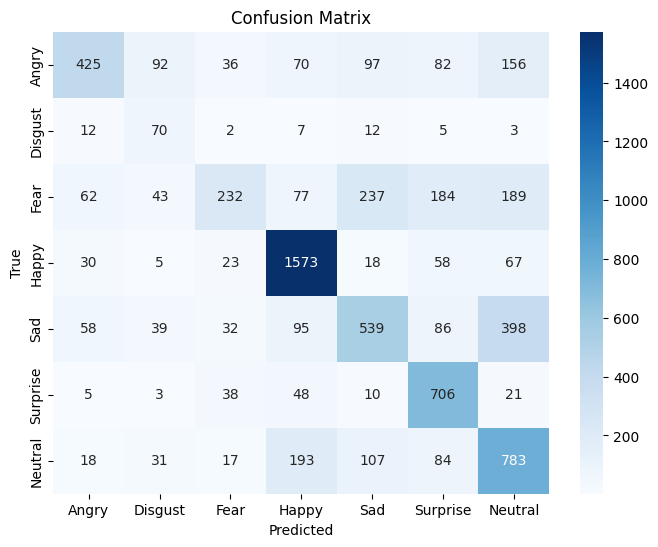

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Save Model


In [30]:
torch.save(model.state_dict(), "fer_efficientnet_b0_paper.pth")
print("Model saved as fer_efficientnet_b0_paper.pth")

Model saved as fer_efficientnet_b0_paper.pth
